In [65]:
from lib import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [66]:
users, finder_decisions = load_data()
finder_decisions['Decision'] = finder_decisions['Decision'] == 'like'
finder_decisions, finder_decisions_valid = train_test_split(finder_decisions, test_size=0.2, random_state=42)

### EDA

In [32]:
decision_value_counts = finder_decisions['Decision'].value_counts()
print('Like/skip proportion: {:.2f}%'.format(100 * decision_value_counts[1] / decision_value_counts[0]))

Like/skip proportion: 35.98%


In [33]:
sender_value_counts = finder_decisions['Sender_id'].value_counts()
print('Senders with <10 choices: {:.2f}%'.format(100 * (sender_value_counts < 10).sum() / len(sender_value_counts)))

Senders with <10 choices: 9.85%


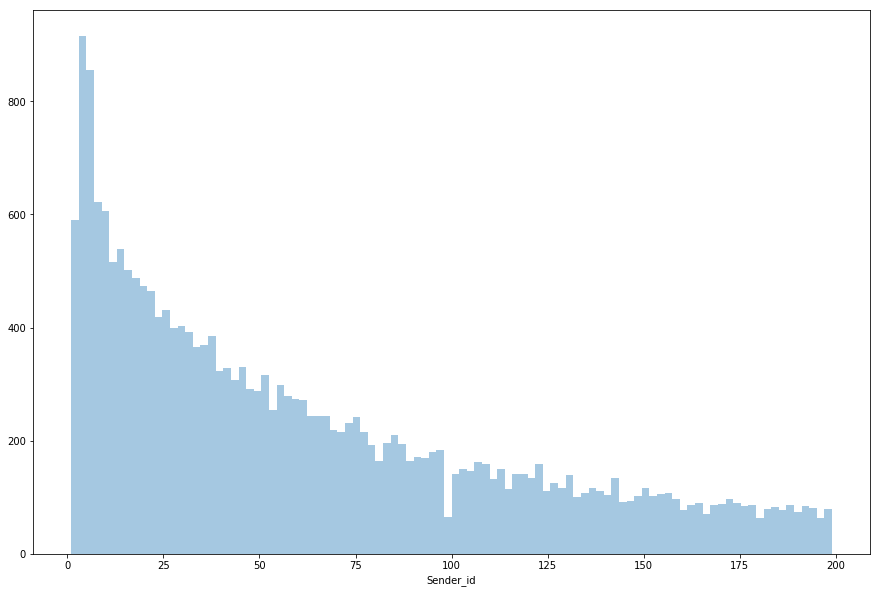

In [34]:
plt.figure(figsize=(15,10))
ax = sns.distplot(sender_value_counts[sender_value_counts<200], kde=False, bins=100)

In [35]:
receiver_value_counts = finder_decisions['Receiver_id'].value_counts()
print('Receivers with <10 choices: {:.2f}%'.format(100 * (receiver_value_counts < 10).sum() / len(receiver_value_counts)))

Receivers with <10 choices: 16.13%


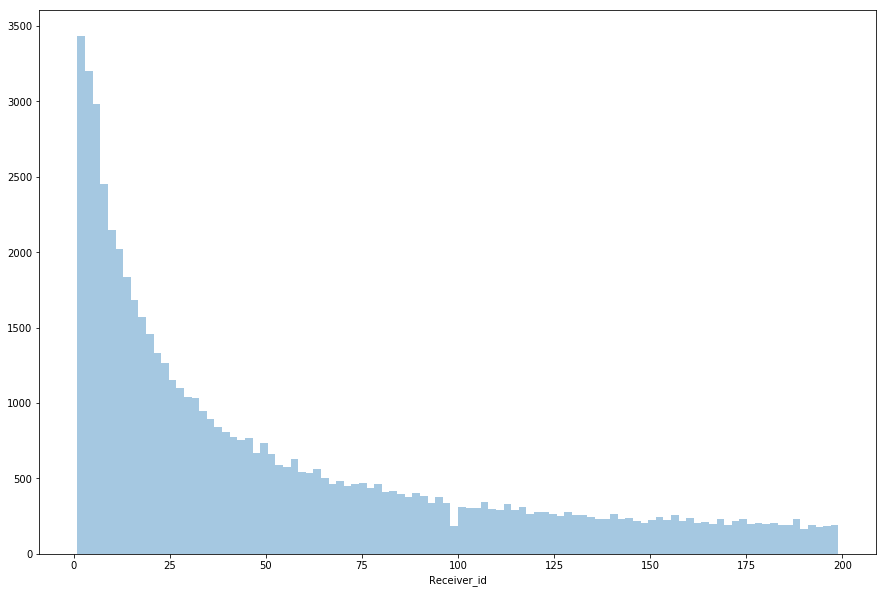

In [36]:
plt.figure(figsize=(15,10))
ax = sns.distplot(receiver_value_counts[receiver_value_counts<200], kde=False, bins=100)

In [37]:
finder_decisions = finder_decisions.merge(users, how='left', left_on='Sender_id', right_index=True)
finder_decisions.rename(columns={'age': 'Sender_age', 'gender': 'Sender_gender'}, inplace=True)
finder_decisions = finder_decisions.merge(users, how='left', left_on='Receiver_id', right_index=True)
finder_decisions.rename(columns={'age': 'Receiver_age', 'gender': 'Receiver_gender'}, inplace=True)

finder_decisions['decision_on_own_gender'] = finder_decisions['Sender_gender'] == finder_decisions['Receiver_gender']
print('Decisions on own gender: {:.4f}%'.format(100*(finder_decisions['decision_on_own_gender']).sum()/len(finder_decisions)))

user_likes_not_own_gender = finder_decisions[finder_decisions['Decision']].groupby('Sender_id')['decision_on_own_gender'].mean()>0.5
print('Users like not own gender: {:.4f}%'.format(100*user_likes_not_own_gender.sum()/len(user_likes_not_own_gender)))

Decisions on own gender: 1.8267%
Users like not own gender: 2.2070%


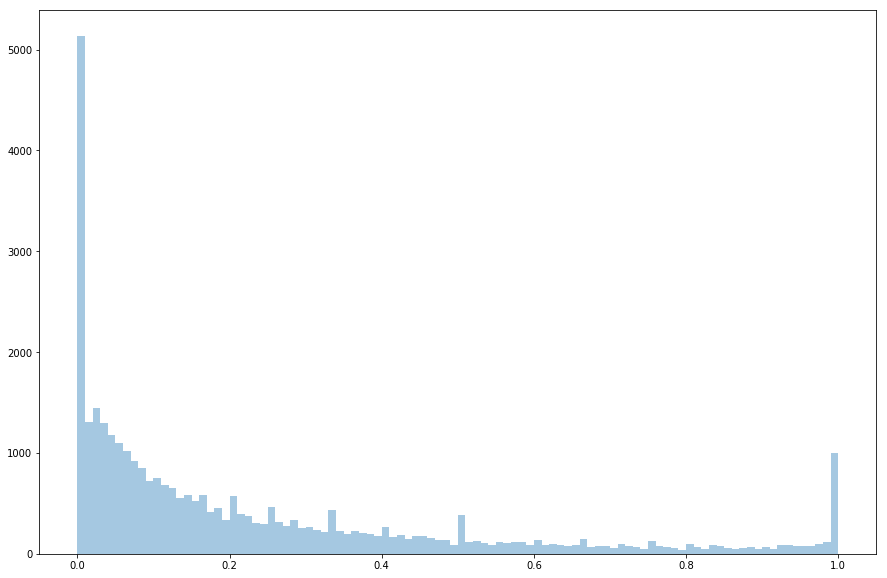

In [42]:
mean_decision_per_user = finder_decisions.groupby('Sender_id').agg({'Decision': 'mean'})
plt.figure(figsize=(15,10))
ax = sns.distplot(mean_decision_per_user.values, kde=False, bins=100)
plt.xlabel('Decision proportion per user, 1 - all likes, 0 - all skips')
plt.ylabel('Users number')

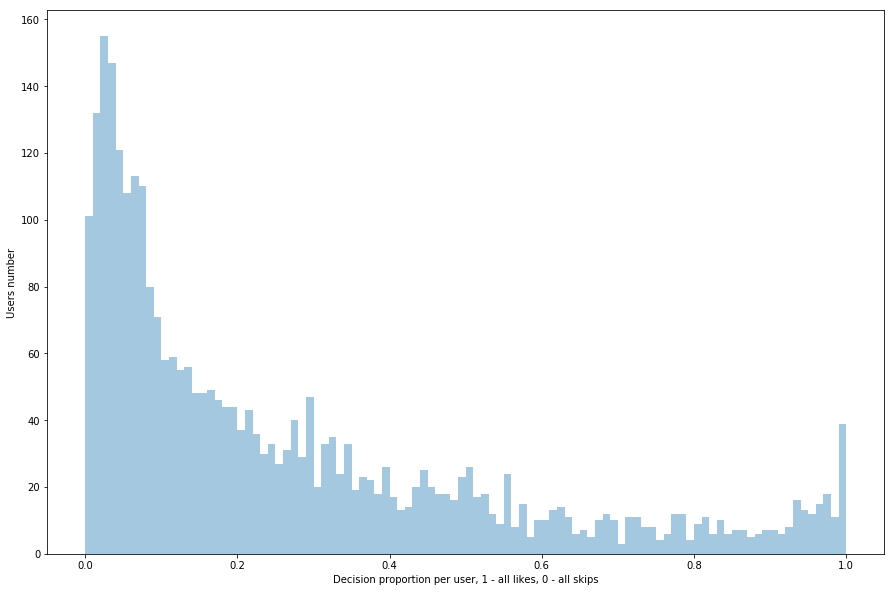

In [53]:
sender_ids_more_than100_decisions = sender_value_counts[sender_value_counts > 100].index.values
mean_decision_per_user = finder_decisions[finder_decisions['Sender_id'].isin(sender_ids_more_than100_decisions)].groupby('Sender_id').agg({'Decision': 'mean'})
plt.figure(figsize=(15,10))
ax = sns.distplot(mean_decision_per_user.values, kde=False, bins=100)
plt.xlabel('Decision proportion per user with >100 decisions, 1 - all likes, 0 - all skips')
plt.ylabel('Users number')

### Baseline models

In [68]:
random_decisions = np.random.choice([True, False], size=len(finder_decisions_valid))
print('Random decision accuracy: {}'.format((random_decisions == finder_decisions_valid['Decision']).sum()/len(random_decisions)))

Random decision accuracy: 0.49952472005522536


In [69]:
print('All skip accuracy: {}'.format((~finder_decisions_valid['Decision']).sum()/len(random_decisions)))

All skip accuracy: 0.7355076270824042


### Popularity model

In [106]:
receiver_likes = finder_decisions[finder_decisions['Decision']][['Decision','Receiver_id']].groupby('Receiver_id').count()['Decision']

In [116]:
popularity_accuracies = pd.Series(index=np.linspace(0, 1 ,11))
for quantile in popularity_accuracies.index.values:
    quantile_ids = receiver_likes.index[(receiver_likes > receiver_likes.quantile(quantile)).values]
    popularity_decisions = finder_decisions_valid['Receiver_id'].isin(quantile_ids)
    popularity_accuracies[quantile] = (finder_decisions_valid['Decision'] == popularity_decisions).sum()/len(popularity_decisions)

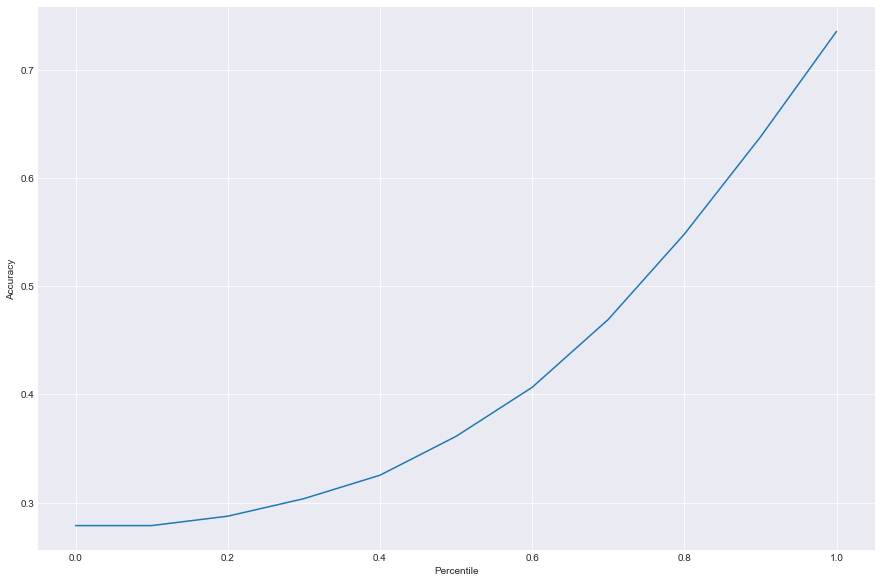

In [133]:
plt.figure(figsize=(15,10))
sns.set_style("darkgrid")
plt.plot(popularity_accuracies.index.values, popularity_accuracies.values)
plt.xlabel('Quantile')
plt.ylabel('Accuracy')

Decisions on own gender: 1.7004%
Users like not own gender: 2.2501%


### Likeability model

In [185]:
receiver_likeability = finder_decisions[['Decision','Receiver_id']].groupby('Receiver_id').mean()['Decision']

In [186]:
likeability_accuracies = pd.Series(index=np.linspace(0, 1 ,11))
for likeability_threshold in likeability_accuracies.index.values:
    quantile_ids = receiver_likeability.index[receiver_likeability > likeability_threshold]
    likeability_decisions = finder_decisions_valid['Receiver_id'].isin(quantile_ids)
    likeability_accuracies[likeability_threshold] = (finder_decisions_valid['Decision'] == likeability_decisions).sum()/len(likeability_decisions)

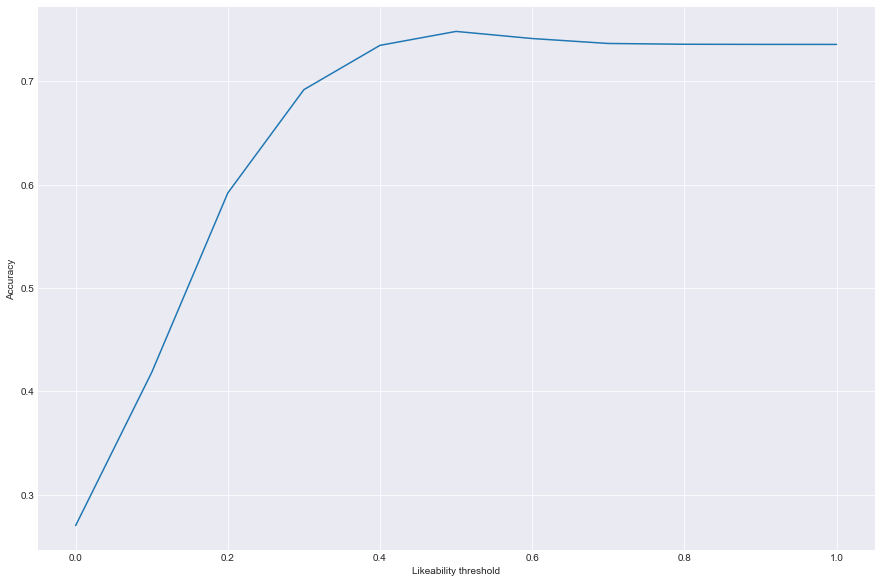

In [188]:
plt.figure(figsize=(15,10))
sns.set_style("darkgrid")
plt.plot(likeability_accuracies.index.values, likeability_accuracies.values)
plt.xlabel('Likeability threshold')
plt.ylabel('Accuracy')

In [ ]:
# from surprise import SVD, evaluate, Dataset, Reader
# svd = SVD()
# reader = Reader(rating_scale=(0,1))

# data = Dataset.load_from_df(finder_decisions[['Sender_id', 'Receiver_id', 'Decision']], reader)
# test = Dataset.load_from_df(finder_decisions_valid[['Sender_id', 'Receiver_id', 'Decision']], reader)
# svd.fit(train)
# predictions = svd.test(test)
# preds = np.array([p.est > 0.5 for p in predictions])
# print((preds == finder_decisions_valid['Decision']).sum()/len(preds))
